In [1]:
import pandas as pd
pd.set_option('display.max_columns', 60)

import numpy as np
import re
import json
from pathlib import Path
import re

import matplotlib.pyplot as plt

import utils

[nltk_data] Downloading package punkt to /home/ruecker/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Reading in sample data

In [2]:
raw = utils.read_data('200707_aachener_zeitung.txt')

b'Skipping line 116: expected 52 fields, saw 54\nSkipping line 180: expected 52 fields, saw 53\nSkipping line 215: expected 52 fields, saw 53\nSkipping line 308: expected 52 fields, saw 55\nSkipping line 461: expected 52 fields, saw 55\nSkipping line 625: expected 52 fields, saw 53\n'


In [3]:
raw.head()

,articleId,pageviews,entrances,exits,bounces,timeOnPage,conversions,avgTimeOnPage,stickiness,entranceRate,bounceRate,sharePageviews,n,nObs,score_pageviews,score_avgTimeOnPage,score_entranceRate,score_stickiness,SCORE,kategorie,rubrik,subRubrik,titel,pagePath,dpaGuid,categoryCode,creationDate,flextags,genre,geoArea,importance,keywords,lifetime,limbic,links,picture,service,subject,subjectBroader,subjectCode,teaser,text,titelH1,titelH3,urgency,wikidata,wordcount,category,ratgeber,format,dateLoaded,nLoadAttempts
0,48620281,21,7,12,7,1012,NaN,112.444444,42.857143,33.333333,33.333333,100,1,20,3,12,3,15,33,ratgeber,gesundheit,NaN,die-richtigen-schuhe-fuers-joggen,https://www.aachener-zeitung.de/ratgeber/gesun...,200110-99-421545,dpacat:vm,2020-01-29 04:07:01,NaN,"Fragen & Antworten__,__Fragen und Antworten",Deutschland,NaN,"Ratgeber__,__Joggen__,__Laufschuhe__,__Messen_...",NaN,NaN,NaN,NaN,dpasrv:tmn,"Gesundheit__,__Sport__,__Medizin__,__Freizeit","Medizin, Gesundheit__,__sp__,__Gesundheitspers...","dpasubject:346__,__medtop:15000000__,__medtop:...","Wer ein bisschen durch den Park rennen möchte,...",München/Stuttgart (dpa/tmn) - Frische Luft und...,Ohne Treter läuft nichts: Die richtigen Schuhe...,NaN,3,NaN,769,vm,1,NewsML-G2,2020-04-21 19:33:11,1
1,48620381,19,6,11,5,1484,NaN,185.500000,42.105263,31.578947,26.315789,100,1,18,2,14,3,15,34,ratgeber,gesundheit,NaN,wann-ist-der-winter-blues-eine-depression,https://www.aachener-zeitung.de/ratgeber/gesun...,200122-99-580227,dpacat:vm,2020-01-29 04:06:00,NaN,KORR-Bericht,Deutschland,NaN,"Ratgeber__,__Psychologie__,__Depressionen__,__...",NaN,NaN,Info-Telefon Depression,NaN,dpasrv:tmn,"Gesundheit__,__Medizin","Medizin, Gesundheit__,__Gesundheitspersonal","dpasubject:346__,__medtop:20000485","Ewig grauer Himmel, Nässe, Kälte. Je länger de...",Berlin/Frankfurt/Main (dpa/tmn) - Der Wecker k...,Ohne Antrieb: Wann ist der Winter-Blues eine D...,NaN,4,NaN,441,vm,1,NewsML-G2,2020-04-21 19:33:11,1
2,48622639,2,2,2,2,0,NaN,0.000000,0.000000,100.000000,100.000000,100,1,2,1,0,20,0,21,ratgeber,familie,NaN,klassische-babyphones-weiter-besser,https://www.aachener-zeitung.de/zva/amp-gtm.ht...,200127-99-652209,dpacat:vm,2020-01-29 05:30:03,NaN,Zusammenfassung,Deutschland,NaN,"Eltern__,__Kinder__,__Ratgeber__,__Baby__,__Ba...",NaN,NaN,Test-Artikel,NaN,dpasrv:tmn,"Familie__,__Technik","Gesellschaft, Bevölkerung__,__Technologie und ...","medtop:20000780__,__dpasubject:300",Schläfst du noch oder schreist du schon? Babyp...,Berlin (dpa/tmn) - Eltern auf der Suche nach e...,Funk statt WLAN: Klassische Babyphones weiter ...,NaN,3,NaN,390,vm,1,NewsML-G2,2020-04-21 19:33:11,1
3,48623085,32,9,20,9,974,NaN,81.166667,37.500000,28.125000,28.125000,100,1,30,4,10,3,14,31,ratgeber,bauen-wohnen,NaN,die-besten-spuelmaschinen-multitabs-kosten-sie...,https://www.aachener-zeitung.de/ratgeber/bauen...,200128-99-665065,dpacat:vm,2020-01-29 05:25:01,NaN,Zusammenfassung,Deutschland,NaN,"Ratgeber__,__Stiftung Warentest__,__Spülmaschinen",NaN,NaN,Ergebnisse Spülmaschinentabs-Test Stiftung War...,NaN,dpasrv:tmn,"Immobilien__,__Wohnen__,__Verbraucher__,__Umwelt","Bau__,__Wohnungsbau__,__Kunde__,__Politik__,__...","medtop:20000241__,__dpasubject:303__,__medtop:...","Dosierfach auf, Tab rein, Klappe zu, Maschine ...",Berlin (dpa/tmn) - Spülmaschinentabs sollen kl...,Warentest: Die besten Spülmaschinen-Multitabs ...,NaN,3,NaN,345,vm,1,NewsML-G2,2020-04-21 19:33:11,1
4,48623259,24,2,7,2,3797,NaN,223.352941,70.833333,8.333333,8.333333,100,1,20,3,15,1,20,39,ratgeber,lifestyle,NaN,so-schneidet-make-up-beim-warentest-ab,https://www.aachener-zeitung.de/ratgeber/lifes...,200128-99-667871,dpacat:vm,2020-01-29 05:00:12,NaN,Meldung,Deutschland,NaN,"tmn0500__,__Lifestyle__,__Ratgeber__,__Stiftun...",NaN,NaN,NaN,NaN,dpasrv:tmn,"Mode__,__Kosmetik","Kunst und Unterhaltung__,__Chemie","medtop:20000011__,__medtop:20000220",Make-up mit toller Deckkraft und trotzdem natü...,Berlin (dpa/tmn) - Make-up hat heutzutage eine...,Ist das noch natürlich? - Stift

## Creating dict with descriptions of columns from meta file

In [4]:
meta_dict = utils.create_meta_dict()

In [5]:
len(meta_dict)

52

In [6]:
meta_dict['pageviews']

'Anzahl Seitenaufrufe'

In [7]:
for var in meta_dict.keys():
    if meta_dict[var] != 'tbi':
        print(var,':', meta_dict[var])

articleId : ID (aus CMS des Publishers)
pageviews : Anzahl Seitenaufrufe
entrances : Anzahl Einstiege
exits : Anzahl Ausstiege
bounces : Anzahl Bounces
timeOnPage : Verweil- oder Lesedauer in Sekunden (insgesamt)
conversions : Anzahl Registrierungen/Abos
avgTimeOnPage : durchschnittliche Verweil- oder Lesedauer in Sekunden
stickiness : Anteil der Leser, die im Anschluss an den Artikel auf der Publisher-Seite blieben
entranceRate : Anteil der Leser, die über den Artikel auf die Publisher-Seite kamen
bounceRate : Anteil der Leser, die Publisher-Seite direkt wieder verlassen haben
kategorie : Kategorie in der der Publisher den Artikel veröffentlicht hat
rubrik : Unter-Kategorie
subRubrik : UNter-Unter-Kategorie
titel : Titel (Publisher)
pagePath : URL
dpaGuid : ID aus dpa DWH
categoryCode : vm = "Vermischtes"
genre : dto
geoArea : Regioninfo
keywords : Keyword-Liste durch "__,__" getrennt
links : Weiterführende Links zum Artikel, die die dpa bereitstellt
subject : Subject-Liste durch "__,

In [8]:
raw.columns

Index(['articleId', 'pageviews', 'entrances', 'exits', 'bounces', 'timeOnPage',
       'conversions', 'avgTimeOnPage', 'stickiness', 'entranceRate',
       'bounceRate', 'sharePageviews', 'n', 'nObs', 'score_pageviews',
       'score_avgTimeOnPage', 'score_entranceRate', 'score_stickiness',
       'SCORE', 'kategorie', 'rubrik', 'subRubrik', 'titel', 'pagePath',
       'dpaGuid', 'categoryCode', 'creationDate', 'flextags', 'genre',
       'geoArea', 'importance', 'keywords', 'lifetime', 'limbic', 'links',
       'picture', 'service', 'subject', 'subjectBroader', 'subjectCode',
       'teaser', 'text', 'titelH1', 'titelH3', 'urgency', 'wikidata',
       'wordcount', 'category', 'ratgeber', 'format', 'dateLoaded',
       'nLoadAttempts'],
      dtype='object')

In [9]:
# ignore colums with 'tbi' in meta_dict
use_columns = [var for var in meta_dict.keys() if meta_dict[var] != 'tbi']
df = raw[use_columns]
df.set_index('articleId', inplace=True)

In [10]:
df = utils.add_meta_columns(df)

In [11]:
df.columns

Index(['pageviews', 'entrances', 'exits', 'bounces', 'timeOnPage',
       'conversions', 'avgTimeOnPage', 'stickiness', 'entranceRate',
       'bounceRate', 'kategorie', 'rubrik', 'subRubrik', 'titel', 'pagePath',
       'dpaGuid', 'categoryCode', 'genre', 'geoArea', 'keywords', 'links',
       'subject', 'teaser', 'text', 'titelH1', 'titelH3', 'wordcount',
       'category', 'city', 'text_preprocessed', 'nr_tokens',
       'mean_token_length', 'nr_tokens_teaser', 'nr_tokens_titelH1', 'nr_char',
       'nr_sentences', 'mean_sentence_length', 'avgTimeOnPage/wordcount',
       'avgTimeOnPage/nr_char', 'pageviews-exits'],
      dtype='object')

In [12]:
df.shape

(891, 40)

In [13]:
df.head()

,pageviews,entrances,exits,bounces,timeOnPage,conversions,avgTimeOnPage,stickiness,entranceRate,bounceRate,kategorie,rubrik,subRubrik,titel,pagePath,dpaGuid,categoryCode,genre,geoArea,keywords,links,subject,teaser,text,titelH1,titelH3,wordcount,category,city,text_preprocessed,nr_tokens,mean_token_length,nr_tokens_teaser,nr_tokens_titelH1,nr_char,nr_sentences,mean_sentence_length,avgTimeOnPage/wordcount,avgTimeOnPage/nr_char,pageviews-exits
articleId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
48620281,21,7,12,7,1012,,112.444444,42.857143,33.333333,33.333333,ratgeber,gesundheit,,die-richtigen-schuhe-fuers-joggen,https://www.aachener-zeitung.de/ratgeber/gesun...,200110-99-421545,dpacat:vm,"Fragen & Antworten__,__Fragen und Antworten",Deutschland,"Ratgeber__,__Joggen__,__Laufschuhe__,__Messen_...",,"Gesundheit__,__Sport__,__Medizin__,__Freizeit","Wer ein bisschen durch den Park rennen möchte,...",München/Stuttgart (dpa/tmn) - Frische Luft und...,Ohne Treter läuft nichts: Die richtigen Schuhe...,,769,vm,München/Stuttgart,Frische Luft und Bewegung: Diese Kombination r...,796,5.359296,29,9,5148,52.0,15.307692,0.146222,0.021842,9
48620381,19,6,11,5,1484,,185.500000,42.105263,31.578947,26.315789,ratgeber,gesundheit,,wann-ist-der-winter-blues-eine-depression,https://www.aachener-zeitung.de/ratgeber/gesun...,200122-99-580227,dpacat:vm,KORR-Bericht,Deutschland,"Ratgeber__,__Psychologie__,__Depressionen__,__...",Info-Telefon Depression,"Gesundheit__,__Medizin","Ewig grauer Himmel, Nässe, Kälte. Je länger de...",Berlin/Frankfurt/Main (dpa/tmn) - Der Wecker k...,Ohne Antrieb: Wann ist der Winter-Blues eine D...,,441,vm,Berlin/Frankfurt/Main,"Der Wecker klingelt, aufstehen! Doch gerade im...",452,5.938053,33,8,3182,28.0,16.142857,0.420635,0.058297,8
48622639,2,2,2,2,0,,0.000000,0.000000,100.000000,100.000000,ratgeber,familie,,klassische-babyphones-weiter-besser,https://www.aachener-zeitung.de/zva/amp-gtm.ht...,200127-99-652209,dpacat:vm,Zusammenfassung,Deutschland,"Eltern__,__Kinder__,__Ratgeber__,__Baby__,__Ba...",Test-Artikel,"Familie__,__Technik",Schläfst du noch oder schreist du schon? Babyp...,Berlin (dpa/tmn) - Eltern auf der Suche nach e...,Funk statt WLAN: Klassische Babyphones weiter ...,,390,vm,Berlin,Eltern auf der Suche nach einem guten Babyphon...,396,5.848485,30,7,2776,26.0,15.230769,0.000000,0.000000,0
48623085,32,9,20,9,974,,81.166667,37.500000,28.125000,28.125000,ratgeber,bauen-wohnen,,die-besten-spuelmaschinen-multitabs-kosten-sie...,https://www.aachener-zeitung.de/ratgeber/bauen...,200128-99-665065,dpacat:vm,Zusammenfassung,Deutschland,"Ratgeber__,__Stiftung Warentest__,__Spülmaschinen",Ergebnisse Spülmaschinentabs-Test Stiftung War...,"Immobilien__,__Wohnen__,__Verbraucher__,__Umwelt","Dosierfach auf, Tab rein, Klappe zu, Maschine ...",Berlin (dpa/tmn) - Spülmaschinentabs sollen kl...,Warentest: Die besten Spülmaschinen-Multitabs ...,,345,vm,Berlin,Spülmaschinentabs sollen kleine Alleskönner se...,367,5.594005,30,7,2442,23.0,15.956522,0.235266,0.033238,12
48623259,24,2,7,2,3797,,223.352941,70.833333,8.333333,8.333333,ratgeber,lifestyle,,so-schneidet-make-up-beim-warentest-ab,https://www.aachener-zeitung.de/ratgeber/lifes...,200128-99-667871,dpacat:vm,Meldung,Deutschland,"tmn0500__,__Lifestyle__,__Ratgeber__,__Stiftun...",,"Mode__,__Kosmetik",Make-up mit toller Deckkraft und trotzdem natü...,Berlin (dpa/tmn) - Make-up hat heutzutage eine...,Ist das noch natürlich? - Stiftung Warentest p...,,182,vm,Berlin,Make-up hat heutzutage einen Zweck: Es soll da...,183,5.622951,22,8,1243,8.0,22.875000,1.227214,0.179689,17


In [14]:
df.describe().round(4)

,pageviews,entrances,exits,bounces,timeOnPage,avgTimeOnPage,stickiness,entranceRate,bounceRate,wordcount,nr_tokens,mean_token_length,nr_tokens_teaser,nr_tokens_titelH1,nr_char,nr_sentences,mean_sentence_length,avgTimeOnPage/wordcount,avgTimeOnPage/nr_char,pageviews-exits
count,891.0000,891.0000,891.0000,891.0000,891.0000,891.0000,891.0000,891.0000,891.0000,891.0000,891.0000,891.0000,891.0000,891.0000,891.0000,891.0000,891.0000,891.0000,891.0000,891.0000
mean,35.4590,16.1639,20.3625,14.3210,2114.9529,114.6680,58.2550,28.1088,24.4739,340.4063,344.7329,5.8368,25.8249,7.9192,2375.5488,21.1852,16.2811,0.4201,0.0600,15.0965
std,189.9885,113.5783,131.1531,102.7342,11761.1282,125.9725,24.7289,26.0652,24.7995,211.2220,217.7269,0.3857,5.4935,1.5579,1464.2997,13.2597,3.0126,0.5579,0.0802,69.6400
min,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,74.0000,73.0000,4.6659,0.0000,3.0000,501.0000,4.0000,8.6731,0.0000,0.0000,0.0000
25%,6.0000,1.0000,2.0000,0.0000,187.0000,45.6000,43.6141,6.2500,0.0000,171.0000,169.0000,5.5761,24.0000,7.0000,1204.0000,11.0000,14.2727,0.1667,0.0240,3.0000
50%,10.0000,2.0000,3.0000,2.0000,494.0000,80.0000,60.0000,21.7391,18.1818,262.0000,262.0000,5.7953,27.0000,8.0000,1853.0000,16.0000,15.8889,0.2892,0.0416,6.0000
75%,17.0000,5.0000,7.0000,4.0000,1177.5000,143.4405,75.0000,42.8571,39.1447,492.5000,504.0000,6.0776,29.0000,9.0000,3485.0000,29.5000,17.8730,0.4743,0.0676,10.0000
max,3047.0000,1877.0000,2032.0000,1779.0000,217337.0000,1490.0000,100.0000,100.0000,100.0000,1374.0000,1431.0000,7.2606,36.0000,13.0000,10167.0000,97.0000,30.5500,6.7727,1.0074,1354.0000


In [15]:
df.iloc[100] # one example

pageviews                                                                 12
entrances                                                                  6
exits                                                                      6
bounces                                                                    4
timeOnPage                                                              1133
conversions                                                                 
avgTimeOnPage                                                        188.833
stickiness                                                                50
entranceRate                                                              50
bounceRate                                                           33.3333
kategorie                                                           ratgeber
rubrik                                                            gesundheit
subRubrik                                                                   

In [16]:
df.loc[50415599, 'nr_sentences']

5.0

In [17]:
df.loc[48620281, 'text'][:500]

'München/Stuttgart (dpa/tmn) - Frische Luft und Bewegung: Diese\nKombination reizt viele Menschen am Laufen. Damit die Muskeln und\nSehnen eine Joggingrunde gut überstehen, spielt das Schuhwerk eine\nzentrale Rolle. Anders gesagt: Ohne Laufschuhe läuft nichts. Warum\ndas so ist und worauf es bei den Modellen ankommt:\n\nReicht für den Start nicht der alte Hallenschuh?\n\nNein. «Ein Hallenschuh ist sicher nicht geeignet, um einen etwa auf\nWaldboden weit zu tragen», erklärt der Orthopäde Patrik Reize. Beim'

In [18]:
df.loc[48620281, 'text_preprocessed'][:500]

'Frische Luft und Bewegung: Diese Kombination reizt viele Menschen am Laufen. Damit die Muskeln und Sehnen eine Joggingrunde gut überstehen, spielt das Schuhwerk eine zentrale Rolle. Anders gesagt: Ohne Laufschuhe läuft nichts. Warum das so ist und worauf es bei den Modellen ankommt: Reicht für den Start nicht der alte Hallenschuh? Nein. «Ein Hallenschuh ist sicher nicht geeignet, um einen etwa auf Waldboden weit zu tragen», erklärt der Orthopäde Patrik Reize. Beim Laufen würden andere Fußteile b'

In [19]:
utils.show_article(ID=49333693, df = df) #48623259 # 50175481

pageviews: 2487
nr_tokens: 770
nr_tokens_titelH1: 6
nr_tokens_teaser: 22
avgTimeOnPage/wordcount: 0.3918469551282057
stickiness: 18.2951347004423
-----
titelH1
Covid-19: Welche Regeln gelten im Betrieb?
-----
teaser
Die Verbreitung des neuartigen Coronavirus betrifft auch die Arbeitswelt. Unternehmen ordnen Homeoffice an, Infizierte und Kontaktpersonen sind in Quarantäne. Was gilt arbeitsrechtlich?
-----
text_preprocessed
Nachdem mehr und mehr Fälle von Covid-19-Infektionen in Deutschland und Europa bekannt werden, müssen auch Unternehmen reagieren. Welche Regeln gelten hier für Arbeitnehmer? Die wichtigsten Fragen und Antworten: Können Arbeitnehmer aus Angst vor dem Virus von zu Hause aus arbeiten? Wer Angst hat, sich am Arbeitsplatz oder außerhalb der eigenen vier Wände anzustecken, kann als Arbeitnehmer nicht einfach zuhause bleiben. Das gilt nur für Personen, die tatsächlich arbeitsunfähig sind, erklärt der DGB Rechtsschutz. Wenn im Betrieb aber die Arbeit im Homeoffice ohnehin übl

In [20]:
# saving modified (deleted and added columns) DataFrame (df) to encrypted folder
df.to_csv(utils.ROOT / '200707_aachener_zeitung_modified.csv')

## looking at genre, rubrik, kategorie, keywords, ...

In [21]:
def get_meta_file_categorical_variable(column_name, seperator="__,__"):
    value_set = set()
    for d in df[column_name]:
        candidates = d.split(seperator)
        for c in candidates:
            value_set.add(c.strip())
    value_df = pd.DataFrame(data=0, index = df.index, columns = sorted(list(value_set)))
    for i, value in df[column_name].items():
        candidates = value.split(seperator)
        for c in candidates:
            value_df.loc[i, c.strip()] = 1
    return value_df

In [22]:
df_city = get_meta_file_categorical_variable('city', seperator="/")
df_city.to_csv('meta_file_city.csv', index=True) # save to file
print(df_city.sum(axis=0))

Aachen        3
Alsdorf       1
Alzenau       1
Amberg        1
Amsterdam     1
             ..
Witten        1
Wolfsburg     1
Worms         1
Zürich        2
Überlingen    2
Length: 150, dtype: int64


In [23]:
df_geoArea = get_meta_file_categorical_variable('geoArea')
df_geoArea.to_csv('meta_file_geoArea.csv', index=True) # save to file
print(df_geoArea.sum(axis=0))

                   1
Deutschland      884
Frankreich         1
Indien             1
International      1
Italien            2
Schweiz            8
Uganda             1
Österreich         9
dtype: int64


In [24]:
df_genre = get_meta_file_categorical_variable('genre')
df_genre.to_csv('meta_file_genre.csv', index=True) # save to file
print(df_genre.sum(axis=0))

Extra                      2
Fragen & Antworten        29
Fragen und Antworten      17
Hintergrund                8
Interview                 13
KORR-Bericht             227
Meldung                  492
Themendienst-Gespräch     13
Umfrage                    1
Zusammenfassung          106
dtype: int64


In [25]:
df_rubrik = get_meta_file_categorical_variable('rubrik')
df_rubrik.to_csv('meta_file_rubrik.csv', index=True) # save to file
print(df_rubrik.sum(axis=0))

                  10
aachen             1
auto             163
bauen-wohnen     146
bildung-beruf     92
essen-trinken     84
familie          114
gesundheit       146
lifestyle         31
recht             51
reisen            50
themenwelten       3
dtype: int64


In [26]:
df.subRubrik.value_counts() # ?????

                                                                                                                                                                                                                           889
darf-ich-meinen-dienstwagen-verleihen_aid-51534897&author=Aachener Zeitung&date=2020-06-08T04:19:00+0200&datePublished=2020-06-08 04:19&dateModified=2020-06-08 04:23&daysSincePublication=+0 days&origin=2&seo=             1
arbeitsplatz-kollegen-rivalitaet-als-ansporn_aid-51535141&author=Aachener Zeitung&date=2020-06-08T04:59:00+0200&datePublished=2020-06-08 04:59&dateModified=2020-06-08 05:03&daysSincePublication=+2 days&origin=4&seo=      1
Name: subRubrik, dtype: int64

In [30]:
df_kategorie = get_meta_file_categorical_variable('kategorie')
df_kategorie.to_csv('meta_file_kategorie.csv', index=True) # save to file
print(df_kategorie.sum(axis=0))

lokales         1
nrw-region      9
ratgeber      878
sonstiges       3
dtype: int64


In [31]:
df_keywords = get_meta_file_categorical_variable('keywords')
df_keywords.to_csv('meta_file_keywords.csv', index=True) # save to file
print(df_keywords.sum(axis=0))

KeyboardInterrupt: 

In [32]:
df_subject = get_meta_file_categorical_variable('subject')
df_subject.to_csv('meta_file_subject.csv', index=True) # save to file
print(df_subject.sum(axis=0))

Arbeit                114
Automobilindustrie      1
Ernährung              82
Essen und Trinken       2
Familie               106
Finanzen                5
Freizeit                1
Gesundheit            155
Immobilien            177
Kosmetik                1
Medizin                 3
Mode                   29
Recht                   1
Sport                   2
Steuern                 1
Technik                 7
Tier                    1
Tourismus              39
Umwelt                  1
Verbraucher            14
Verkehr               170
Wohnen                  2
dtype: int64


In [33]:
# Liste von "subjects"
subjects = utils.get_set_of_meta_cat('subject')
subjects

['Arbeit',
 'Automobilindustrie',
 'Ernährung',
 'Essen und Trinken',
 'Familie',
 'Finanzen',
 'Freizeit',
 'Gesundheit',
 'Immobilien',
 'Kosmetik',
 'Medizin',
 'Mode',
 'Recht',
 'Sport',
 'Steuern',
 'Technik',
 'Tier',
 'Tourismus',
 'Umwelt',
 'Verbraucher',
 'Verkehr',
 'Wohnen']

In [34]:
test = utils.get_articles_where(df, meta_cat = 'subject', label = 'Verbraucher')
test

,pageviews,entrances,exits,bounces,timeOnPage,conversions,avgTimeOnPage,stickiness,entranceRate,bounceRate,kategorie,rubrik,subRubrik,titel,pagePath,dpaGuid,categoryCode,genre,geoArea,keywords,links,subject,teaser,text,titelH1,titelH3,wordcount,category,city,text_preprocessed,nr_tokens,mean_token_length,nr_tokens_teaser,nr_tokens_titelH1,nr_char,nr_sentences,mean_sentence_length,avgTimeOnPage/wordcount,avgTimeOnPage/nr_char,pageviews-exits
articleId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
48623085,32,9,20,9,974,,81.166667,37.500000,28.125000,28.125000,ratgeber,bauen-wohnen,,die-besten-spuelmaschinen-multitabs-kosten-sie...,https://www.aachener-zeitung.de/ratgeber/bauen...,200128-99-665065,dpacat:vm,Zusammenfassung,Deutschland,"Ratgeber__,__Stiftung Warentest__,__Spülmaschinen",Ergebnisse Spülmaschinentabs-Test Stiftung War...,"Immobilien__,__Wohnen__,__Verbraucher__,__Umwelt","Dosierfach auf, Tab rein, Klappe zu, Maschine ...",Berlin (dpa/tmn) - Spülmaschinentabs sollen kl...,Warentest: Die besten Spülmaschinen-Multitabs ...,,345,vm,Berlin,Spülmaschinentabs sollen kleine Alleskönner se...,367,5.594005,30,7,2442,23.0,15.956522,0.235266,0.033238,12
48626959,18,3,10,3,761,,95.125000,44.444444,16.666667,16.666667,ratgeber,gesundheit,,die-laufschuh-trends-fuer-die-saison-2020,https://www.aachener-zeitung.de/ratgeber/gesun...,200116-99-504295,dpacat:vm,Zusammenfassung,Deutschland,"Ratgeber__,__Laufen__,__Joggen__,__Messen__,__...",,"Gesundheit__,__Verbraucher__,__Sport","Dämpfen, stützen, federn: Die Technik in den L...",München (dpa/tmn) - Wie gut sie passen und wie...,Rebound und Algenschaum: Die Laufschuh-Trends ...,,679,vm,München,Wie gut sie passen und wie komfortabel sie sic...,687,5.710335,29,9,4688,49.0,14.020408,0.140096,0.020291,8
48643915,6,2,3,2,141,,47.000000,50.000000,33.333333,33.333333,ratgeber,auto,,batterieauto-lohnt-mehr-als-hybridfahrzeug,https://www.aachener-zeitung.de/ratgeber/auto/...,191205-99-22557,dpacat:vm,Meldung,Deutschland,"Ratgeber__,__Geld__,__Beruf__,__Autos__,__Mobi...",,"Finanzen__,__Verbraucher__,__Steuern__,__Arbeit",E-Autos sollen Verbrenner bald ablösen. Um die...,Berlin (dpa/tmn) - Wer ein dienstliches E-Auto...,E-Auto vom Chef: Batterieauto lohnt mehr als H...,,173,vm,Berlin,"Wer ein dienstliches E-Auto privat nutzt, muss...",174,6.580460,22,8,1333,9.0,19.333333,0.271676,0.035259,3
48675525,2,0,0,0,24,,12.000000,100.000000,0.000000,0.000000,ratgeber,familie,,kindergeld-beantragen-geht-kostenlos,https://www.aachener-zeitung.de/ratgeber/famil...,200131-99-715727,dpacat:vm,Meldung,Deutschland,"Ratgeber__,__Familie__,__Eltern__,__Finanzen__...","Kindergeld-Antrag für Neugeborene__,__Kinderge...",Verbraucher,Bei den Familienkassen gehen vermehrt Anträge ...,Nürnberg (dpa/tmn) - Der Antrag auf Kindergeld...,Vermittler-Gebühr unnötig: Kindergeld beantrag...,,82,vm,Nürnberg,Der Antrag auf Kindergeld bei den regionalen F...,81,6.901235,25,6,650,7.0,11.571429,0.146341,0.018462,2
49466765,127,19,30,7,11837,,122.030928,76.377953,14.960630,5.511811,nrw-region,,,verbraucher-duerfen-himmelslaternen-nur-kaufen,https://www.aachener-zeitung.de/nrw-region/ver...,200309-99-255357,dpacat:vm,Meldung,Deutschland,"Recht__,__Ratgeber__,__Geld__,__Himmelslaternen",,Verbraucher,Manchmal ist die Rechtslage widersprüchlich. S...,Düsseldorf (dpa/tmn) - Sie fliegen mit hell le...,Zünden verboten: Verbraucher dürfen Himmelslat...,,176,vm,Düsseldorf,Sie fliegen mit hell leuchtender Flamme am Him...,170,6.494118,26,7,1299,13.0,13.076923,0.693358,0.093942,97
49473155,1887,712,1006,587,169090,,191.929625,46.687864,37.731849,31.107578,nrw-region,,,diese-rechte-haben-ticketinhaber,https://www.aachener-zeitung.de/nrw-region/die...,200310-99-262298,dpacat:vm,Fragen & Antworten,Deutschland,"Krankheiten__,__Recht__,__Corona__,__Coronavir...","eventim: Coronavirus__,__VZ Bremen: Rechte Tic...",Verbraucher,Wegen des neuen Coronavirus werden Konzerte un...,Düsseldorf (dpa/tmn) - Um die Verbreitung des ...,Veranstaltung wegen Corona abge

In [35]:
df.category.unique() # same as categoryCode, not very informative...

array(['vm'], dtype=object)

In [36]:
df.categoryCode.unique() # same as category, not very informative...

array(['dpacat:vm'], dtype=object)

In [37]:
df.agg({'pageviews': ['min', 'max', 'mean', 'median', 'std'],
        'timeOnPage': ['min', 'max', 'mean', 'median', 'std'],
        'avgTimeOnPage': ['min', 'max', 'mean', 'median', 'std'],
        'avgTimeOnPage/wordcount' : ['min', 'max', 'mean', 'median', 'std'],
        'entrances': ['min', 'max', 'mean', 'median', 'std'],
        'pageviews-exits': ['min', 'max', 'mean', 'median', 'std'],
        'stickiness': ['min', 'max', 'mean', 'median', 'std'],
        'wordcount': ['min', 'max', 'mean', 'median', 'std'], # bereits in den Original-Daten
        'nr_tokens': ['min', 'max', 'mean', 'median', 'std'],
        'nr_tokens_titelH1': ['min', 'max', 'mean', 'median', 'std'],
        'nr_tokens_teaser': ['min', 'max', 'mean', 'median', 'std'],
        'nr_sentences': ['min', 'max', 'mean', 'median', 'std'],
        'mean_sentence_length': ['min', 'max', 'mean', 'median', 'std'],
       })

,pageviews,timeOnPage,avgTimeOnPage,avgTimeOnPage/wordcount,entrances,pageviews-exits,stickiness,wordcount,nr_tokens,nr_tokens_titelH1,nr_tokens_teaser,nr_sentences,mean_sentence_length
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,74.000000,73.000000,3.000000,0.000000,4.000000,8.673077
max,3047.000000,217337.000000,1490.000000,6.772727,1877.000000,1354.000000,100.000000,1374.000000,1431.000000,13.000000,36.000000,97.000000,30.550000
mean,35.459035,2114.952862,114.667955,0.420131,16.163861,15.096521,58.255002,340.406285,344.732884,7.919192,25.824916,21.185185,16.281071
median,10.000000,494.000000,80.000000,0.289234,2.000000,6.000000,60.000000,262.000000,262.000000,8.000000,27.000000,16.000000,15.888889
std,189.988507,11761.128249,125.972488,0.557882,113.578326,69.639987,24.728936,211.222006,217.726863,1.557938,5.493478,13.259656,3.012587


In [ ]:
#df.sort_values(by=['avgTimeOnPage/wordcount'], ascending = False)
#df.sort_values(by=['pageviews'], ascending = False)
#df.sort_values(by=['mean_token_length'])
#df.sort_values(by=['avgTimeOnPage'], ascending = False)
df.sort_values(by=['avgTimeOnPage/nr_char'], ascending = False)
#df.sort_values(by=['pageviews-exits'], ascending = False)
#df.sort_values(by=['stickiness'], ascending = False)

In [ ]:
df[['pageviews', 'entrances', 'exits', 'bounces', 'timeOnPage', 'avgTimeOnPage', 'avgTimeOnPage/wordcount', 'stickiness', 'nr_tokens', 'nr_tokens_teaser', 'nr_tokens_titelH1']].describe().round(2)

In [ ]:
plt.hist(df.wordcount, density=False, bins=30)

In [ ]:
#plt.hist(df.pageviews, density=False, bins=30)
plt.hist(df[df.pageviews <200].pageviews, density=False, bins=30)

# man sieht: die allermeisten Artikel haben 0-50 pageviews, es gibt eber riesige Ausreißer nach oben, wie damit umgehen?

In [ ]:
plt.hist(df[df.timeOnPage <4000].timeOnPage, density=False, bins=30)

In [ ]:
plt.hist(df[df.entrances <150].entrances, density=False, bins=30)

In [ ]:
plt.hist(df[df.avgTimeOnPage <400].avgTimeOnPage, density=False, bins=30)

In [ ]:
plt.hist(df['avgTimeOnPage/wordcount'], density=False, bins=30)

In [ ]:
plt.hist(df['avgTimeOnPage/nr_char'], density=False, bins=30)

In [ ]:
import seaborn as sns
sns.boxplot(x=df.pageviews)

In [ ]:
# sorted to see it better
#plt.plot(df.sort_values(by=['timeOnPage'], ascending = False).timeOnPage.to_numpy(), label = 'timeOnPage')
plt.plot(df.sort_values(by=['pageviews'], ascending = False).pageviews.to_numpy(), label = 'pageviews')
plt.legend()

## inspecting avgTimeOnPage

In [ ]:
plt.plot(df.sort_values(by=['avgTimeOnPage'], ascending = False).avgTimeOnPage.to_numpy(), label = 'avgTimeOnPage')

In [ ]:
df.sort_values(by=['avgTimeOnPage'], ascending = False).head(10)

In [ ]:
# just take articles with >= 10 pageviews and with ...
df_cut = df.loc[(df['pageviews'] >= 10) ]
#                & (df['avgTimeOnPage/wordcount'] <= 1)
#                & (df['avgTimeOnPage/wordcount'] >= 0.1)]

In [ ]:
df_cut

In [ ]:
df_cut_sorted = df_cut.sort_values(by = ['stickiness'], ascending = False)
df_cut_sorted

In [ ]:
for i in [0,1,2,3,4,5,400,401,402]:
    print(df_cut_sorted.iloc[i]['pageviews-exits'])
    print(df_cut_sorted.iloc[i]['avgTimeOnPage/wordcount'])
    print(df_cut_sorted.iloc[i]['stickiness'])
    print(df_cut_sorted.iloc[i].text_preprocessed)

In [ ]:
#plt.plot(df_cut.sort_values(by=['avgTimeOnPage/wordcount'], ascending = False)['avgTimeOnPage/wordcount'].to_numpy(), label = 'avgTimeOnPage/wordcount')
plt.plot(df_cut.sort_values(by=['stickiness'], ascending = False)['stickiness'].to_numpy(), label = 'stickiness')

In [ ]:
plt.hist(df_cut['avgTimeOnPage/wordcount'], density=False, bins=30)

(array([ 43.,  10.,  15.,  42.,  47.,  29.,  59., 104.,  64.,  72., 143.,
         77.,  91.,  36.,  59.]),
 array([  0.        ,   6.66666667,  13.33333333,  20.        ,
         26.66666667,  33.33333333,  40.        ,  46.66666667,
         53.33333333,  60.        ,  66.66666667,  73.33333333,
         80.        ,  86.66666667,  93.33333333, 100.        ]),
 <a list of 15 Patch objects>)

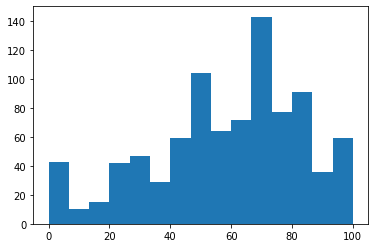

In [103]:
plt.hist(df['stickiness'], density=False, bins=15)

{'whiskers': [<matplotlib.lines.Line2D at 0x7ff6a1e86d90>,
 'caps': [<matplotlib.lines.Line2D at 0x7ff6a1e89850>,
 'boxes': [<matplotlib.lines.Line2D at 0x7ff6a1e86850>],
 'medians': [<matplotlib.lines.Line2D at 0x7ff6a1e91350>],
 'fliers': [<matplotlib.lines.Line2D at 0x7ff6a1e91890>],
 'means': []}

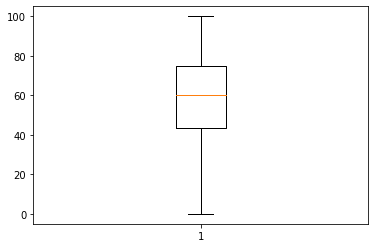

In [106]:
#plt.boxplot(df_cut['avgTimeOnPage/wordcount'])
#plt.boxplot(df_cut['pageviews'])
plt.boxplot(df.stickiness)

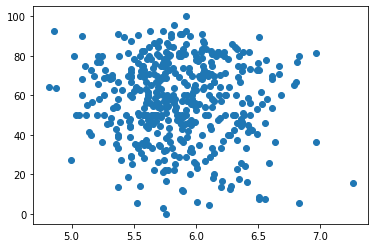

In [108]:
plt.scatter(df_cut.mean_token_length, df_cut.stickiness)

In [55]:
# zeigt TimeOnPage/wordcount aufgespalten nach subject-Kategorien
for s in subjects:
    print(s)
    tmp = utils.get_articles_where(df=df, meta_cat = 'subject', label = s)
    print(np.mean(tmp['avgTimeOnPage/wordcount']))
    print(np.mean(tmp['stickiness']))

Arbeit
0.3953509819250898
38.490602150192146
Automobilindustrie
0.23121827411167512
90.9090909090909
Ernährung
0.4674141111785935
68.10580123944732
Essen und Trinken
0.43383366881380814
67.24310776942355
Familie
0.4574435936660513
59.04797988602787
Finanzen
0.5783040420314773
46.43029617053386
Freizeit
0.14622164427105852
42.8571428571429
Gesundheit
0.38048090223017156
59.59361666709484
Immobilien
0.39322307279286167
65.02493283383171
Kosmetik
1.2272139625080822
70.8333333333333
Medizin
0.37367535986726996
45.78111946532999
Mode
0.3554135967367521
66.61196938593588
Recht
0.3944567627494457
50.0
Sport
0.14315868664215664
43.650793650793645
Steuern
0.27167630057803466
50.0
Technik
0.3917630193094949
44.95526341758852
Tier
0.2217107786728038
56.410256410256395
Tourismus
0.5957341783261109
46.97519931956457
Umwelt
0.2352657004830919
37.5
Verbraucher
0.32546843184466695
49.77506577685232
Verkehr
0.42132315812093757
60.23762525275048
Wohnen
0.3148612316162688
43.75


Kommentar:
* ich glaube: avgTimeOnPage = timeOnPage/(pageviews - exits)
* stickiness = (pageviews-exits)/pageviews (wieviele der Besucher bleiben beim publisher?)